In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install JPype1-1.2.0-cp38-cp38-win_amd64.whl
!pip install konlpy==0.5.2
!pip install tweepy==3.10.0
!pip install keybert

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: JPype1-1.2.0-cp38-cp38-win_amd64.whl is not a supported wheel on this platform.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 66.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.6/465.6 KB 42.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 KB 11.6 MB/s eta 0:00:00
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.

In [3]:
import pandas as pd
import numpy as np
import random
import re, string
from konlpy.tag import Komoran, Hannanum
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from keybert import KeyBERT

In [431]:
data = pd.read_csv('/content/drive/MyDrive/1. preprocessing/1-2. ESG report/output/ESG_text_hyundaehomeshopping_2023.csv', encoding = 'utf-8-sig')
data_raw = data.copy()
data_raw.head()

,text,label
0,현대홈쇼핑은 주주가치 증진 및 권익보호를 위해 투명하고 합리적이며 안정적인 경영기반...,g
1,(現) 현대홈쇼핑 대표이사 사장 (前) 현대홈쇼핑 영업본부장 (前) 현대홈쇼핑 경영...,g
2,(現) 현대홈쇼핑 영업본부장 전무이사 (前) 현대홈쇼핑 생활사업부장 (前) 현대홈쇼...,g
3,현대홈쇼핑은 이사 선임 시 전문성과 개인적 역량을 검증하여 주주총회에 후보자를 상정...,g
4,이사회의 효율적이고 전문적인 의사결정을 위해 이사회 내 총 7개의 위원회(감사위원회...,g


1. 전처리

In [7]:
komoran = Komoran()
hannanum = Hannanum()

In [130]:
# 불용어 파일 열기
with open('/content/drive/MyDrive/1. preprocessing/stopwords.txt', 'r', encoding='ISO-8859-1') as f:
    list_file = f.readlines() 
stopwords = list_file[0].split(",")

In [432]:
data_pre = data_raw.copy()
data_pre['noun'] = ''
# for i, j in data_pre.iterrows():
#   print(type(j['text']))
#   data_pre.iloc[i, 'noun'] = finalpreprocess("\n".join([s for s in j['text'].split("\n") if s]))
try:
  data_pre['noun'] = data_pre['text'].apply(lambda x : ' '.join([n for n in komoran.nouns(x) if n not in stopwords and len(n)>1 and n not in ['현대', '현대홈쇼핑']]))
except:
  pass

In [433]:
data_pre

,text,label,noun
0,현대홈쇼핑은 주주가치 증진 및 권익보호를 위해 투명하고 합리적이며 안정적인 경영기반...,g,주주 가치 증진 권익 보호 투명 합리 안정 경영 기반 노력 이사회 회사 최고 의사 ...
1,(現) 현대홈쇼핑 대표이사 사장 (前) 현대홈쇼핑 영업본부장 (前) 현대홈쇼핑 경영...,g,대표 이사 사장 영업 본부장 경영 지원 본부장
2,(現) 현대홈쇼핑 영업본부장 전무이사 (前) 현대홈쇼핑 생활사업부장 (前) 현대홈쇼...,g,영업 본부장 전무이사 생활 사업 부장 사업 부장
3,현대홈쇼핑은 이사 선임 시 전문성과 개인적 역량을 검증하여 주주총회에 후보자를 상정...,g,이사 선임 전문 개인 역량 검증 주주총회 후보자 상정 후보자 역량 평가 이사회 선임...
4,이사회의 효율적이고 전문적인 의사결정을 위해 이사회 내 총 7개의 위원회(감사위원회...,g,이사회 효율 전문 의사 결정 이사회 위원회 감사 위원회 사외이사 후보 추천 위원회 ...
...,...,...,...
100,(<https://image.hmall.com/company/files/busine...,s,.com 공정 거래
101,현대홈쇼핑은 모든 협력사를 존중하며 상호협력을 통한 공동발전을 추구합니다. 또한 당...,s,협력 존중 상호 협력 공동 발전 추구 당사 협력 상호 신뢰 소통 이해 바탕 상생 파...
102,공정한 거래질서 확립을 위해 2021년 9월 『공정거래 자율준수 편람』내 최신 법 ...,s,공정 거래 질서 확립 9월 공정 거래 자율 준수 최신 위반 사례 반영 개정 5월 공...
103,직매입 상품의 부당반품 행위를 사전 예방하여 협력사와의 공정거래를 강화하고자 반품 ...,s,매입 상품 부당 반품 행위 사전 예방 협력 사와 공정 거래 강화 반품 계약 공정 거...


In [434]:
data_pre = data_pre[~data_pre['text'].str.contains('https://')]

In [435]:
e = data_pre[data_pre['label']=='e'].copy()
s = data_pre[data_pre['label']=='s'].copy()
g = data_pre[data_pre['label']=='g'].copy()

2. 클러스터링

In [436]:
df = pd.DataFrame(columns = ['cluster_num', 'keyword', 'text', 'label'])

In [463]:
data_now = g.copy()

In [464]:
text = data_now['noun']

In [465]:
def tfidf_vectorizer(text, min_df=3, ngram_range=(1,5)):
    tfidf_vectorizer = TfidfVectorizer(min_df = 3, ngram_range=(1,5)) #min_df :최소 빈도값 (단어 등장하는 문서 수)
    tfidf_vectorizer.fit(text)
    vector = tfidf_vectorizer.transform(text).toarray()
    vector = np.array(vector) # Normalizer를 이용해 이미 변환된 벡터
    return vector

vector_1st = tfidf_vectorizer(text, min_df=1)

In [466]:
model = DBSCAN(eps=0.1,min_samples=1, metric = "cosine") 
#     거리 계산 식으로는 Cosine distance를 이용
#     eps이 낮을수록, min_samples 값이 높을수록 군집으로 판단하는 기준이 까다로움.
result_1st = model.fit_predict(vector_1st)
data_now['cluster1st'] = result_1st

print('군집개수 :', result_1st.max())
data_now

군집개수 : 9


,text,label,noun,cluster1st
0,현대홈쇼핑은 주주가치 증진 및 권익보호를 위해 투명하고 합리적이며 안정적인 경영기반...,g,주주 가치 증진 권익 보호 투명 합리 안정 경영 기반 노력 이사회 회사 최고 의사 ...,0
1,(現) 현대홈쇼핑 대표이사 사장 (前) 현대홈쇼핑 영업본부장 (前) 현대홈쇼핑 경영...,g,대표 이사 사장 영업 본부장 경영 지원 본부장,1
2,(現) 현대홈쇼핑 영업본부장 전무이사 (前) 현대홈쇼핑 생활사업부장 (前) 현대홈쇼...,g,영업 본부장 전무이사 생활 사업 부장 사업 부장,2
3,현대홈쇼핑은 이사 선임 시 전문성과 개인적 역량을 검증하여 주주총회에 후보자를 상정...,g,이사 선임 전문 개인 역량 검증 주주총회 후보자 상정 후보자 역량 평가 이사회 선임...,3
4,이사회의 효율적이고 전문적인 의사결정을 위해 이사회 내 총 7개의 위원회(감사위원회...,g,이사회 효율 전문 의사 결정 이사회 위원회 감사 위원회 사외이사 후보 추천 위원회 ...,4
5,"현대홈쇼핑은 이사회의 권한과 책임, 운영 절차 등을 구체적으로 규정한 이사회 운영 ...",g,이사회 권한 책임 운영 절차 구체 규정 이사회 운영 규정 바탕 이사회 효율 합리 운...,5
6,"현대홈쇼핑은 2021년도부터 이사회 및 사외이사 평가 제도를 도입 하였으며, 평가 ...",g,년대 이사회 사외이사 평가 제도 도입 평가 결과 이사회 사업 보고서 공시 사외이사 ...,6
7,현대홈쇼핑은 2021년 11월 이사회 내 ESG 경영위원회를 신설하고 위원회와 추진...,g,11월 이사회 경영 위원회 신설 위원회 추진 협의체 중심 부문 경영 실천 지속 성장...,7
8,현대홈쇼핑은 건전하고 투명한 지배구조 확립에 대한 의지 공표 및 주주 등 모든 이해...,g,투명 지배 구조 확립 의지 공표 주주 이해관계자 지배 구조,8
9,관한 구체적인 정보를 제공함으로써 신뢰를 확보하기 위해 2019년 8월 기업지배구조...,g,구체 정보 제공 신뢰 확보 8월 기업지배구조 헌장 신규 제정 2월 개정안 발표 당사...,9


In [467]:
def print_cluster_result(train, result, col_cluster):
    # train : 데이터, result : 군집화 결과, col_cluster : 클러스터넘버 컬럼명
    clusters = []
    counts = []
    thumbnails = []
    nouns = []
    labels = []
    for cluster_num in set(result):
            print("cluster num : {}".format(cluster_num))
            temp_df = train[train[col_cluster] == cluster_num] # cluster num 별로 조회
            clusters.append(cluster_num)
            counts.append(len(temp_df))
            thumbnails.append(temp_df.reset_index()['text'][0])
            nouns.append(temp_df.reset_index()['noun'][0]) 
            labels.append(temp_df.reset_index()['label'][0])

            for text in temp_df['text']:
                print(text) # 제목으로 살펴보자
            print()

    cluster_result = pd.DataFrame({'cluster_num':clusters, 'count':counts, 'text':thumbnails, 'noun': nouns, 'label':labels})
    return cluster_result


In [468]:
cluster1_result = print_cluster_result( train=data_now, 
                                       result=result_1st, col_cluster="cluster1st")

cluster num : 0
현대홈쇼핑은 주주가치 증진 및 권익보호를 위해 투명하고 합리적이며 안정적인 경영기반을 갖추고자 노력하고 있습니다. 현대홈쇼핑 이사회는 회사의 최고의사결정기구로서 법령 또는 정관이 규정하고 있는 사항, 주주총회를 통해 위임받은 사항, 회사 경영 기본방침 및 업무 진행에 관한 중요 사항을 심의·의결하고 있으며, 경영진의 업무를 감독하고 있습니다. 이사회는 주주총회에서 선임한 7명의 이사로 구성되어 있으며, 경영진과 지배주주로부터 독립적인 기능을 수행할 수 있도록 과반수(2022년 3월 기준, 이사 7명 중 사외이사 4명으로 전체 구성원 대비 57%)를 사외이사로 구성하고 있습니다. 당사 정관에 따라 이사회 임기는 2년으로 하며, 상법에 따라 사외이사의 총 연임 기간은 6년을 초과할 수 없도록 규정하고 있습니다. 

cluster num : 1
(現) 현대홈쇼핑 대표이사 사장 (前) 현대홈쇼핑 영업본부장 (前) 현대홈쇼핑 경영지원본부장 

cluster num : 2
(現) 현대홈쇼핑 영업본부장 전무이사 (前) 현대홈쇼핑 생활사업부장 (前) 현대홈쇼핑 Hmall사업부장 

cluster num : 3
현대홈쇼핑은 이사 선임 시 전문성과 개인적 역량을 검증하여 주주총회에 후보자를 상정하고 있습니다. 후보자의 역량평가 및 이사회 선임에 있어서는 연령, 성별, 학력, 출신 지역 등을 한정하지 않고 다양한 시각에서 독립적으로 판단할 수 있는 후보를 우선적으로 고려하고 있습니다. 객관적인 후보 추천 및 검증을 위해 사외 이사후보추천위원회를 운영하고 있으며, 이사회의 전문성, 책임성, 다양성 확보를 위해 법무/회계/재무/ 세무/방송 등 관련 분야의 지식이나 실무적 경험이 풍부한 전문가로 구성하고 있습니다. 사외이사는 회사에 대하여 언제든지 직무수행에 필요한 정보 제공을 요청하거나 외부 전문가의 자문을 받을 수 있으며, 감사위원회 위원의 경우 내부회계관리제도 관련 법령 및 규정에서 정하는 사항 등에 대한 교육을 실시하여 효과적인 직무수행을 지원하고 

cluster 2

In [469]:
text2 = cluster1_result['noun']
vector_2nd = tfidf_vectorizer(text2, min_df=1)

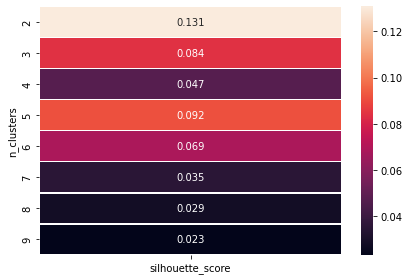

In [470]:
# Silhouette Score - 최적 k
def visualize_silhouette_layer(data, param_init='k-means++', param_n_init=10, param_max_iter=300):
    clusters_range = range(2,min(50,len(data)))
    results = []

    for i in clusters_range:
        clusterer = KMeans(n_clusters=i, init=param_init, n_init=param_n_init, max_iter=param_max_iter, random_state=0)
        cluster_labels = clusterer.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        results.append([i, silhouette_avg])

    result = pd.DataFrame(results, columns=["n_clusters", "silhouette_score"])
    pivot_km = pd.pivot_table(result, index="n_clusters", values="silhouette_score")

    plt.figure()
    sns.heatmap(pivot_km, annot=True, linewidths=.5, fmt='.3f', cmap=sns.cm._rocket_lut)
    plt.tight_layout()
    plt.show()

visualize_silhouette_layer(vector_2nd) # 가장 높은 실루엣 계수와 매핑되는 k

In [472]:
# kmeans 군집 결과 확인
from sklearn.cluster import KMeans

result_2nd = KMeans(n_clusters=2).fit_predict(vector_2nd)
cluster1_result['cluster2nd'] = result_2nd

cluster2_result = print_cluster_result( train=cluster1_result, 
                                       result=result_2nd, col_cluster="cluster2nd")

cluster num : 0
(現) 현대홈쇼핑 영업본부장 전무이사 (前) 현대홈쇼핑 생활사업부장 (前) 현대홈쇼핑 Hmall사업부장 
현대홈쇼핑은 건전하고 투명한 지배구조 확립에 대한 의지 공표 및 주주 등 모든 이해관계자에게 지배구조에 
관한 구체적인 정보를 제공함으로써 신뢰를 확보하기 위해 2019년 8월 기업지배구조 헌장을 신규 제정 하였으며, 2022년 2월 1차 개정안을 발표했습니다. 당사의 기업지배구조 헌장 전문은 홈페이지에서 확인할 수 있습니다. 

cluster num : 1
현대홈쇼핑은 주주가치 증진 및 권익보호를 위해 투명하고 합리적이며 안정적인 경영기반을 갖추고자 노력하고 있습니다. 현대홈쇼핑 이사회는 회사의 최고의사결정기구로서 법령 또는 정관이 규정하고 있는 사항, 주주총회를 통해 위임받은 사항, 회사 경영 기본방침 및 업무 진행에 관한 중요 사항을 심의·의결하고 있으며, 경영진의 업무를 감독하고 있습니다. 이사회는 주주총회에서 선임한 7명의 이사로 구성되어 있으며, 경영진과 지배주주로부터 독립적인 기능을 수행할 수 있도록 과반수(2022년 3월 기준, 이사 7명 중 사외이사 4명으로 전체 구성원 대비 57%)를 사외이사로 구성하고 있습니다. 당사 정관에 따라 이사회 임기는 2년으로 하며, 상법에 따라 사외이사의 총 연임 기간은 6년을 초과할 수 없도록 규정하고 있습니다. 
(現) 현대홈쇼핑 대표이사 사장 (前) 현대홈쇼핑 영업본부장 (前) 현대홈쇼핑 경영지원본부장 
현대홈쇼핑은 이사 선임 시 전문성과 개인적 역량을 검증하여 주주총회에 후보자를 상정하고 있습니다. 후보자의 역량평가 및 이사회 선임에 있어서는 연령, 성별, 학력, 출신 지역 등을 한정하지 않고 다양한 시각에서 독립적으로 판단할 수 있는 후보를 우선적으로 고려하고 있습니다. 객관적인 후보 추천 및 검증을 위해 사외 이사후보추천위원회를 운영하고 있으며, 이사회의 전문성, 책임성, 다양성 확보를 위해 법무/회계/재무/ 세무/방송 등 관련 분야의 지식이나 실무적 경험이 풍부한 전문

키워드 추출

In [75]:
key_model = KeyBERT('paraphrase-multilingual-MiniLM-L12-v2')  #distilbert-base-nli-mean-tokens / paraphrase-multilingual-MiniLM-L12-v2

In [473]:
def keyword(data, col_cluster):  #data = cluster_result (데이터프레임) #1분 30초 소요됨
    result = []
    for i in range(len(data)):
        temp_res = []
        key_text = cluster1_result[cluster1_result[col_cluster]==i]['noun']
        key_text = ' '.join(key_text)
        keyword = key_model.extract_keywords(key_text, keyphrase_ngram_range=(1,2), top_n=5)
        for i in range(min(5, len(keyword))):
          temp_res.append(keyword[i][0])
        result.append(temp_res)
    print(result)
    return result

def merge_keyword(data, col_cluster): #새 열로 추가.
    data_temp = data.copy()
    data_temp['keyword'] = keyword(data, col_cluster)
    return data_temp

keyword_result = merge_keyword(cluster2_result, col_cluster='cluster2nd')

keyword_df = keyword_result[['cluster_num', 'count', 'keyword']]
keyword_df.sort_values(by='count', ascending=False, inplace=True, ignore_index=True)
keyword_df.drop(index=[0], inplace=True)
keyword_df = keyword_df[keyword_df['count']>2]
lst = []
for i in keyword_df['keyword']:
    lst.append([j.upper() for j in i])
keyword_df['keyword'] = lst
keyword_df

[['기업지배구조 헌장', '영업 본부장', '당사 기업지배구조', '본부장', '8월 기업지배구조'], ['주주총회 소집', '주주총회 선임', '본부장 이사', '이사회 주주총회', '감독 이사회']]


/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,cluster_num,count,keyword
1,0,3,"[기업지배구조 헌장, 영업 본부장, 당사 기업지배구조, 본부장, 8월 기업지배구조]"


최종 정리

In [474]:
temp_df = cluster1_result[['text', 'cluster2nd', 'label']]
final = keyword_df.merge(temp_df, left_on='cluster_num', right_on='cluster2nd').drop(columns=['count'])
final_temp = final.loc[:, ['cluster_num', 'keyword', 'text', 'label']] 
final_temp

,cluster_num,keyword,text,label
0,0,"[기업지배구조 헌장, 영업 본부장, 당사 기업지배구조, 본부장, 8월 기업지배구조]",(現) 현대홈쇼핑 영업본부장 전무이사 (前) 현대홈쇼핑 생활사업부장 (前) 현대홈쇼...,g
1,0,"[기업지배구조 헌장, 영업 본부장, 당사 기업지배구조, 본부장, 8월 기업지배구조]",현대홈쇼핑은 건전하고 투명한 지배구조 확립에 대한 의지 공표 및 주주 등 모든 이해...,g
2,0,"[기업지배구조 헌장, 영업 본부장, 당사 기업지배구조, 본부장, 8월 기업지배구조]",관한 구체적인 정보를 제공함으로써 신뢰를 확보하기 위해 2019년 8월 기업지배구조...,g


In [475]:
df = pd.concat([df,final_temp])

In [476]:
df

,cluster_num,keyword,text,label
0,0,"[재생 에너지, 운영 친환경, 단계 친환경, 조성 친환경, 환경오염 문제]","현대홈쇼핑은 회의실 내에 스마트 기기를 비치하여 페이퍼리스 회의 환경을 조성하고, ...",e
1,0,"[재생 에너지, 운영 친환경, 단계 친환경, 조성 친환경, 환경오염 문제]",현대홈쇼핑은 사업 특성상 조직 내 에너지 소비량 중 전력이 차지하는 비중이 높은 만...,e
2,0,"[재생 에너지, 운영 친환경, 단계 친환경, 조성 친환경, 환경오염 문제]",현대홈쇼핑은 물 사용량 감소를 위해 사내 중수도 시설물을 구축했습니다. 이를 통해 ...,e
3,0,"[재생 에너지, 운영 친환경, 단계 친환경, 조성 친환경, 환경오염 문제]","현대홈쇼핑이 배출하는 폐기물은 크게 사무폐기물과 물류폐기물, 그리고 방송폐기물로 나...",e
4,0,"[재생 에너지, 운영 친환경, 단계 친환경, 조성 친환경, 환경오염 문제]",현대홈쇼핑은 LED 스튜디오인 미디어월(Media Wall) 확대를 통해 방송폐기물...,e
5,0,"[재생 에너지, 운영 친환경, 단계 친환경, 조성 친환경, 환경오염 문제]",현대홈쇼핑은 폐기물로 인한 환경오염 문제에 대한 사회적 인식 변화에 맞춰 유통단계에...,e
6,2,"[재활용 장재, 재활용 수지, 재활용 인식도, 추출 재활용, 재활용 분류]",현대홈쇼핑 물류센터에서는 물류 포장재와 관련한 환경 운영 방침을 기반으로 자원순환을...,e
7,2,"[재활용 장재, 재활용 수지, 재활용 인식도, 추출 재활용, 재활용 분류]",현대홈쇼핑은 포장재의 소비/폐기 과정에서 재활용률을 높이기 위해 포장재 겉면에 재활...,e
8,2,"[재활용 장재, 재활용 수지, 재활용 인식도, 추출 재활용, 재활용 분류]",현대홈쇼핑은 물류 포장 시 접착제를 사용하지 않고 100% 종이 소재로 만들어 재활...,e
0,5,"[비용 방송, 협력 방송, 방송 노하우, 영상 제작, 방송 수수료]","현대홈쇼핑은 고객 진정성을 강화하기 위해 Live, 데이터 방송으로 판매되는 주얼리...",s


In [477]:
df.to_csv('/content/drive/MyDrive/1. preprocessing/key_bert_hyundaehomeshopping_2023.csv', index=False, encoding = 'utf-8-sig')